In [1]:
!pip install transformers
!pip install datasets
!mkdir ./checkpoints

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.4 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup # AdamW
from torch.optim import AdamW
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import json

In [3]:
TRAIN_DATA_PATH = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/datasets/WASSA23_essay_level_train_preproc.tsv"
df_train = pd.read_csv(TRAIN_DATA_PATH, sep='\t')
df_train.head(10)

,conversation_id,article_id,essay,empathy,distress,speaker_id,gender,education,race,age,...,essay_id,emotion,Surprise,Hope,Neutral,Sadness,Joy,Fear,Anger,Disgust
0,2,35,It breaks my heart to see people living in tho...,6.833333,6.625,30,1,6,3,37,...,1,Hope/Sadness,0,1,0,1,0,0,0,0
1,3,35,I wonder why there aren't more people trying t...,5.833333,6.000,19,1,6,2,32,...,2,Anger,0,0,0,0,0,0,1,0
2,5,35,"After reading the article, you can't help but ...",1.000000,1.375,17,1,6,1,29,...,4,Sadness,0,0,0,1,0,0,0,0
3,6,213,It is so sad that someone who had such an amaz...,6.166667,6.625,16,2,5,1,28,...,5,Sadness,0,0,0,1,0,0,0,0
4,8,213,"From reading the article, it looks like the wo...",6.833333,1.000,30,1,6,3,37,...,7,Neutral,0,0,1,0,0,0,0,0
5,10,213,That's sad. Regardless of what they find out ...,1.666667,1.125,49,1,5,1,31,...,9,Sadness,0,0,0,1,0,0,0,0
6,11,78,"After reading the article, my reaction is that...",1.500000,1.000,17,1,6,1,29,...,10,Sadness,0,0,0,1,0,0,0,0
7,13,78,It sounds like these boys had a really rough l...,2.000000,1.000,24,2,7,1,38,...,12,Sadness,0,0,0,1,0,0,0,0
8,14,78,This is a tragic and sad story about how some ...,6.000000,3.000,43,2,6,1,33,...,13,Sadness,0,0,0,1,0,0,0,0
9,17,336,Hello. I feel really terrible about the curren...,7.000000,1.000,31,unknown,unknown,unknown,unknown,...,16,Disgust/Sadness,0,0,0,1,0,0,0,1


In [4]:
DEV_DATA_PATH = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/datasets/WASSA23_essay_level_dev_preproc.tsv"
df_dev = pd.read_csv(DEV_DATA_PATH, sep='\t')
df_dev.head(10)

,conversation_id,article_id,essay,speaker_id,gender,education,race,age,income,speaker_number,...,iri_fantasy,iri_empathatic_concern,Sadness,Anger,Surprise,Neutral,Joy,Hope,Disgust,Fear
0,1,35,How sad is it that this kind of pain and suffe...,68,2,2,1,21,20000,1,...,3.143,3.286,1,0,0,0,0,0,0,0
1,4,35,The article is kind of tragic and hits close t...,79,1,6,3,33,64000,1,...,2.429,1.429,1,0,0,0,0,0,0,0
2,7,213,"I think that these kinds of stories, are sad, ...",68,2,2,1,21,20000,1,...,3.143,3.286,1,0,0,0,0,0,0,0
3,9,213,It's crazy that random accidents like this hap...,84,2,4,1,25,55000,1,...,3.571,3.143,0,0,0,1,0,0,0,0
4,12,78,This story makes me so so sad.... As someone w...,68,2,2,1,21,20000,1,...,3.143,3.286,1,0,0,0,0,0,0,0
5,15,78,"After reading the article, my first reaction a...",70,1,6,1,29,85000,1,...,4.143,4.643,1,0,0,0,0,0,0,0
6,16,336,I didn't know coal mining had such adverse eff...,81,1,4,1,30,27000,1,...,4.571,4.000,0,0,0,1,0,0,0,0
7,20,336,This is very sad. I can't imagine having elep...,73,2,7,1,38,42000,1,...,2.571,3.857,1,0,0,0,0,0,0,0
8,23,281,"Guys, reading this article really hits home fo...",63,1,4,1,25,29000,1,...,2.571,4.857,1,0,0,0,0,0,0,0
9,26,171,Hey guys. So I just read this article about Ir...,63,1,4,1,25,29000,1,...,2.571,4.857,0,0,0,1,0,0,0,0


In [5]:
class EmotionsDataset(Dataset):

    def __init__(self, tokenizer, max_len, essay, targets):
        self.tokenizer = tokenizer
        self.max_len = max_len # TODO: ??
        self.essay = essay
        self.targets = targets

    def __len__(self):
        return len(self.essay)

    def __getitem__(self, index):
        essay = str(self.essay[index])
        essay = " ".join(essay.split()) # TODO: replace whitespace(s) with single space (TODO: check! move to preprocessing?)

        inputs = self.tokenizer.encode_plus(
            essay,
            None, # TODO: CHECK!
            add_special_tokens=True, # Adds '[CLS]' and '[SEP]'
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [6]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
OPT_STEP_SIZE = 1
OPT_GAMMA = 0.9
EPOCHS = 2
RANDOM_STATE = 42 # TODO: fix it everywhere?
MODEL_NAME = 'bert-base-cased'


tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, truncation=True)
emotions = ["Sadness", "Anger", "Surprise", "Neutral",	"Joy", "Hope", "Disgust", "Fear"]

gold = [emotion.split('/') for emotion in df_train.emotion]
mlb = MultiLabelBinarizer()
mlb.fit(gold)

train_size = 0.8 # TODO: spostare questa suddivisione in un altro scritp
#df_train = df_train[:10] ######################## TEST SUBSAMPLE ########################
train_dataset = df_train.sample(frac=train_size,random_state=RANDOM_STATE)
val_dataset = df_train.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

gold_train = [emotion.split('/') for emotion in train_dataset.emotion]
gold_val = [emotion.split('/') for emotion in val_dataset.emotion]
gold_test = [emotion.split('/') for emotion in df_dev.emotion]
y_train = mlb.transform(gold_train)
y_val = mlb.transform(gold_val)
y_test = mlb.transform(gold_test) # TODO: rinominare in dev

In [7]:
print("FULL Dataset: {}".format(df_train.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(val_dataset.shape))

training_set = EmotionsDataset(tokenizer=tokenizer, max_len=MAX_LEN, essay=train_dataset.essay, targets=y_train)
#dataframe=train_dataset, tokenizer=tokenizer, max_len=MAX_LEN, target_labels=emotions)
val_set = EmotionsDataset(tokenizer=tokenizer, max_len=MAX_LEN, essay=val_dataset.essay, targets=y_val)
#dataframe=val_dataset, tokenizer=tokenizer, max_len=MAX_LEN, target_labels=emotions)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True, # TODO: SEED?
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
eval_dataloader = DataLoader(val_set, **val_params)

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(emotions)) # TODO: controllare che loss usa

num_training_steps = EPOCHS * len(training_loader)
progress_bar = tqdm(range(num_training_steps))
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")
model.to(device)

training_stats = []
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch+1, EPOCHS))
    print('Training...')

    total_train_loss = 0

    model.train()
    for i, batch in enumerate(training_loader):
        print('  Batch {:>5,}  of  {:>5,}'.format(i+1, len(training_loader)))
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        total_train_loss += outputs.loss.item()
        optimizer.zero_grad()
        outputs.loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # TODO: capire se va bene con qualsiasi loss / funzione di attivazione
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)

    avg_train_loss = total_train_loss / len(training_loader)

    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Validation...")

    model.eval()
    total_eval_loss = 0

    for batch in eval_dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        total_eval_loss += outputs.loss.item()
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        # TODO: calcolare metriche con logits e label_ids

    avg_val_loss = total_eval_loss / len(eval_dataloader)
    print("Validation Loss: {0:.2f}".format(avg_val_loss))

    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        model.save_pretrained('checkpoints/model') # TODO: scriverlo su disco alla fine, qui salvarlo in memoria, salvare anche il toknizer
        """torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"checkpoints/model.pt"
        )"""

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss
        }
    )

FULL Dataset: (792, 32)
TRAIN Dataset: (634, 32)
TEST Dataset: (158, 32)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

  0%|          | 0/318 [00:00<?, ?it/s]

======= CUDA Available =======

======== Epoch 1 / 2 ========
Training...
  Batch     1  of    159
  Batch     2  of    159
  Batch     3  of    159
  Batch     4  of    159
  Batch     5  of    159
  Batch     6  of    159
  Batch     7  of    159
  Batch     8  of    159
  Batch     9  of    159
  Batch    10  of    159
  Batch    11  of    159
  Batch    12  of    159
  Batch    13  of    159
  Batch    14  of    159
  Batch    15  of    159
  Batch    16  of    159
  Batch    17  of    159
  Batch    18  of    159
  Batch    19  of    159
  Batch    20  of    159
  Batch    21  of    159
  Batch    22  of    159
  Batch    23  of    159
  Batch    24  of    159
  Batch    25  of    159
  Batch    26  of    159
  Batch    27  of    159
  Batch    28  of    159
  Batch    29  of    159
  Batch    30  of    159
  Batch    31  of    159
  Batch    32  of    159
  Batch    33  of    159
  Batch    34  of    159
  Batch    35  of    159
  Batch    36  of    159
  Batch    37  of    159
 

In [8]:
# model = BertForSequenceClassification.from_pretrained('checkpoints/model') # to restore saved model

In [9]:
# Create a DataFrame from training statistics
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss
epoch,,
1,0.39,0.32
2,0.28,0.29


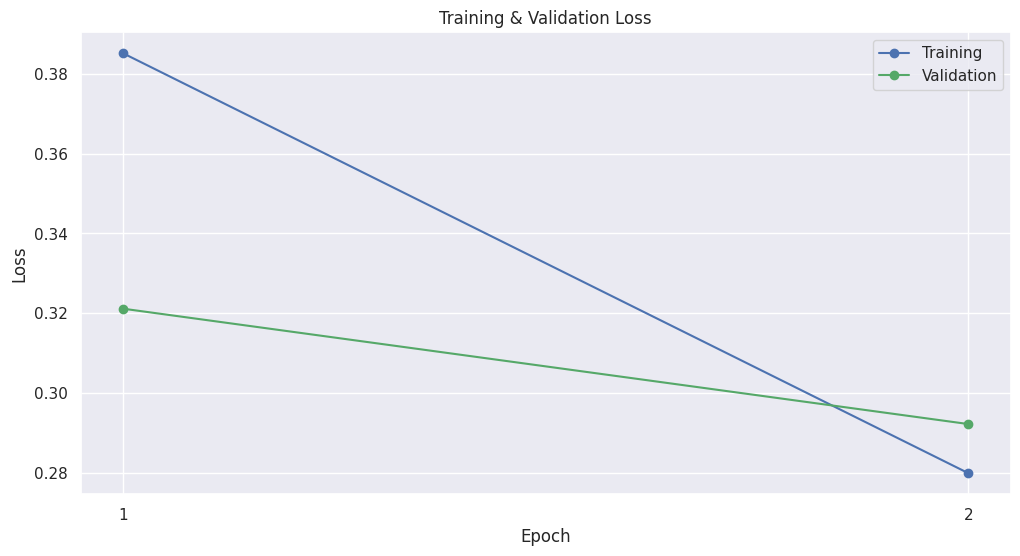

In [10]:
# Plot the learning curve.
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(1, EPOCHS + 1, 1.0))
plt.savefig(MODEL_NAME+"loss_curve.pdf")
plt.show()

In [11]:
def encoded2string(encoded_labels, mlb): # TODO: scrivere meglio... fare classe che codifica e decodifica emozioni
  labels = mlb.inverse_transform(np.array(encoded_labels))
  emotions = ["/".join(emotion) for emotion in labels]
  return emotions

In [12]:
# function used to evaluate emotions
to_round = 4
def calculatePRF_MLabel(gold,prediction):
	"""
	gold/prediction list of list of emo predictions
	"""
	# initialize counters
	# labels = set(gold+prediction)

	gold = [k.lower().split('/') for k in gold]
	prediction = [k.lower().split('/') for k in prediction]

	from sklearn.preprocessing import MultiLabelBinarizer
	from sklearn.metrics import precision_recall_fscore_support, jaccard_score
	mlb = MultiLabelBinarizer()
	mlb.fit(gold)

	y_true = mlb.transform(gold)
	y_pred = mlb.transform(prediction)

	microprecision, microrecall, microf, s = precision_recall_fscore_support(y_true, y_pred, average='micro')
	macroprecision, macrorecall, macroF, s = precision_recall_fscore_support(y_true, y_pred, average='macro')

	accuracy = jaccard_score(y_true, y_pred, average='micro')

	return round(microrecall,to_round),round(microprecision,to_round),round(microf,to_round),round(macrorecall,to_round),round(macroprecision,to_round),round(macroF,to_round),round(accuracy,to_round)

In [13]:
inputs = EmotionsDataset(tokenizer=tokenizer, max_len=MAX_LEN, essay=df_dev.emotion, targets=y_test)
dataloader_in = DataLoader(inputs, batch_size=1, shuffle=False)
predictions = []
targets = []
for batch in dataloader_in:  # TODO: assicurarsi che l'ordine sia lo stesso
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['targets'].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      prediction = [1 if i >= 0.5 else 0 for i in outputs.logits[0]] # TODO: togliere assunzione batch size = 1
      predictions.append(prediction)
      targets.append(labels[0].detach().cpu().numpy())

predictions = encoded2string(predictions, mlb)
targets = encoded2string(targets, mlb)
microrecall, microprecision, microf, macrorecall, macroprecision, macroF, accuracy = calculatePRF_MLabel(targets, predictions) # TODO: prenderli tutti?
scores = {
    'microrecall':microrecall,
    'microprecision':microprecision,
    'microf':microf,
    'macrorecall':macrorecall,
    'macroprecision':macroprecision,
    'macroF':macroF,
    'accuracy':accuracy
}
with open('scores.json', 'w') as fp:
    json.dump(scores, fp)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
print(encoded2string([[1., 0., 0., 0., 0., 0., 1., 0.]], mlb))

['Anger/Sadness']


In [21]:
predictions = ['Sadness','Hope']
df = pd.DataFrame(predictions)
df.to_csv('predictions_EMO.tsv', index=False, header=False, sep='\t')
df

,0
0,Sadness
1,Hope


In [22]:
pd.read_csv('predictions_EMO.tsv', sep='\t', header=None)

,0
0,Sadness
1,Hope


In [15]:
# TODO: capire come gestire se produce tutti 0 per le emzioni
# TODO: perchè da il warning dei pesi?


# TODO: cercare parametri di defualt con cui provarlo e farlo girare su tutti i dati
# TODO: riscrivere in modo modulare, così che basti cambiare il tokenizer e il nome del modello (provare il classificatore con strati sopra? provare a concatenare features?)
# TODO: vedi baselines altri (quali parametri hanno usato)